# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Scaling:
Scale features using standardscaler.

### Step 3: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

## Version Check

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

0.23.4
1.15.4
3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
0.20.1


## Load the Dataset

In [2]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


## Sample view of the training dataset

In [3]:
# first five rows
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Statistical Summary

In [4]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Label Distribution of Training and Test set

In [5]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Step 1: Data preprocessing:
One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features. 
Requirement for One-Hot-encoding:
"The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number.

## Identify categorical features

In [6]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [7]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
### Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

# LabelEncoder

### Insert categorical features into a 2D numpy array

In [8]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


### Make column names for dummies

In [9]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

## Transform categorical features into numbers using LabelEncoder()

In [10]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


# One-Hot-Encoding

In [101]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add 6 missing categories from train set to test set

In [12]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_http_8001',
 'service_red_i',
 'service_urh_i',
 'service_aol',
 'service_harvest']

In [13]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

## Join encoded categorical dataframe with the non-categorical dataframe

In [14]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


# Split Dataset into 4 datasets for every attack category
Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.

Replace labels column with new labels column

Make new datasets


In [15]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [16]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Step 2: Feature Scaling:

In [17]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [18]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [103]:
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
#scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler1.transform(X_DoS_test) 
#scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler2.transform(X_Probe_test) 
#scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler3.transform(X_R2L_test) 
#scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler4.transform(X_U2R_test) 

### Check that the Standard Deviation is 1

In [20]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [21]:
X_Probe.std(axis=0);
X_R2L.std(axis=0);
X_U2R.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [22]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

C:\Users\shang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  UserWarning)


(113270, 13)

### Get the features that were selected: DoS

In [23]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [24]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

C:\Users\shang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 4 16] are constant.
  UserWarning)


(78999, 13)

### Get the features that were selected: Probe

In [25]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [26]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

C:\Users\shang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(68338, 13)

### Get the features that were selected: R2L

In [27]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [28]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

C:\Users\shang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(67395, 13)

### Get the features that were selected: U2R

In [29]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

# Summary of features selected by Univariate Feature Selection

In [30]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_R2L)
print()
print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Features selected for Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Features selected for R2L: ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Features selected for U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_

The authors state that "After obtaining the adequate number of features during the univariate selection process, a recursive feature elimination (RFE) was operated with the number of features passed as parameter to identify the features selected". This either implies that RFE is only used for obtaining the features previously selected but also obtaining the rank. This use of RFE is however very redundant as the features selected can be obtained in another way (Done in this project). One can also not say that the features were selected by RFE, as it was not used for this. The quote could however also imply that only the number 13 from univariate feature selection was used. RFE is then used for feature selection trying to find the best 13 features. With this use of RFE one can actually say that it was used for feature selection. However the authors obtained different numbers of features for every attack category, 12 for DoS, 15 for Probe, 13 for R2L and 11 for U2R. This concludes that it is not clear what mechanism is used for feature selection. 

To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.

# 2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)

In [91]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_estimators=10, n_jobs=2)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'flag_SF'), (2, 'count'), (3, 'same_srv_rate'), (4, 'serror_rate'), (5, 'dst_host_srv_count'), (6, 'dst_host_same_srv_rate'), (7, 'logged_in'), (8, 'dst_host_serror_rate'), (9, 'srv_serror_rate'), (10, 'dst_host_count'), (11, 'dst_host_srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [92]:
rfe.fit(X_newProbe, Y_Probe)
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_srv_count'), (2, 'dst_host_same_src_port_rate'), (3, 'service_private'), (4, 'dst_host_diff_srv_rate'), (5, 'service_eco_i'), (6, 'dst_host_rerror_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'rerror_rate'), (9, 'srv_rerror_rate'), (10, 'logged_in'), (11, 'flag_SF'), (12, 'Protocol_type_icmp'), (13, 'dst_host_srv_rerror_rate')]


In [93]:
rfe.fit(X_newR2L, Y_R2L)
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'hot'), (3, 'dst_host_same_src_port_rate'), (4, 'service_ftp_data'), (5, 'dst_host_srv_diff_host_rate'), (6, 'dst_bytes'), (7, 'dst_host_srv_count'), (8, 'is_guest_login'), (9, 'num_failed_logins'), (10, 'service_ftp'), (11, 'service_imap4'), (12, 'flag_RSTO'), (13, 'service_http')]


In [94]:
rfe.fit(X_newU2R, Y_U2R)
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_count'), (3, 'dst_host_srv_count'), (4, 'num_file_creations'), (5, 'root_shell'), (6, 'dst_host_srv_diff_host_rate'), (7, 'dst_host_same_src_port_rate'), (8, 'service_ftp_data'), (9, 'num_shells'), (10, 'service_telnet'), (11, 'urgent'), (12, 'service_http'), (13, 'srv_diff_host_rate')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)

In [95]:
from sklearn.feature_selection import RFE
clf = RandomForestClassifier(n_estimators=10, n_jobs=2)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [96]:
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [97]:
rfe.fit(X_R2L, Y_R2L)
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [98]:
rfe.fit(X_U2R, Y_U2R)
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of features selected by RFE

In [39]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate', 'dst_host_same_src_port_rate', 'Protocol_type_icmp', 'service_ecr_i', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_eco_i', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'num_compromised', 'root_shell', 'num_file_creations', 'count', 'dst_host_count', 'dst_hos

In [40]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Step 4: Build the model:
### Classifier is trained for all features and for reduced features, for later comparison.
#### The classifier model itself is stored in the clf variable.

In [99]:
# all features
clf_DoS=RandomForestClassifier(n_estimators=10, n_jobs=2)
clf_Probe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_R2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_U2R=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_DoS.fit(X_DoS, Y_DoS)
clf_Probe.fit(X_Probe, Y_Probe)
clf_R2L.fit(X_R2L, Y_R2L)
clf_U2R.fit(X_U2R, Y_U2R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
# selected features
clf_rfeDoS=RandomForestClassifier(n_estimators=10, n_jobs=2)
clf_rfeProbe=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeR2L=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeU2R=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Step 5: Prediction & Evaluation (validation):

Using all Features for each category

Confusion Matrices
## DoS

In [43]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [44]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [1. , 0. ],
       [0. , 1. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [45]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9625,86
1,2441,5019


## Probe

In [46]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9522,189
2,1104,1317


## R2L

In [47]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9711,0
3,2882,3


## U2R

In [48]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9711,0
4,63,4


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99819 (+/- 0.00122)
Precision: 0.99825 (+/- 0.00241)
Recall: 0.99598 (+/- 0.00449)
F-measure: 0.99758 (+/- 0.00319)


## Probe

In [50]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99678 (+/- 0.00270)
Precision: 0.99592 (+/- 0.00577)
Recall: 0.99406 (+/- 0.00576)
F-measure: 0.99521 (+/- 0.00507)


## R2L

In [51]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97936 (+/- 0.00681)
Precision: 0.97558 (+/- 0.01016)
Recall: 0.96961 (+/- 0.01135)
F-measure: 0.97199 (+/- 0.00767)


## U2R

In [52]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99755 (+/- 0.00228)
Precision: 0.99074 (+/- 0.05008)
Recall: 0.83551 (+/- 0.11182)
F-measure: 0.91704 (+/- 0.10097)


# RFECV for illustration

In [53]:
%matplotlib inline

Automatically created module for IPython interactive environment


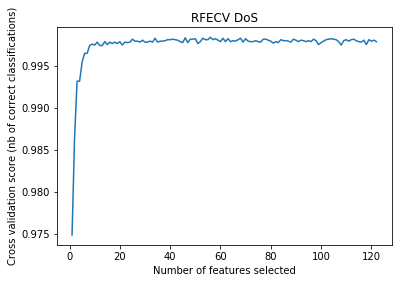

In [54]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

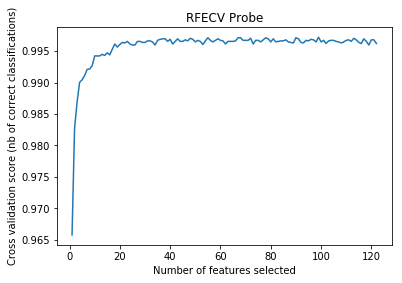

In [55]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

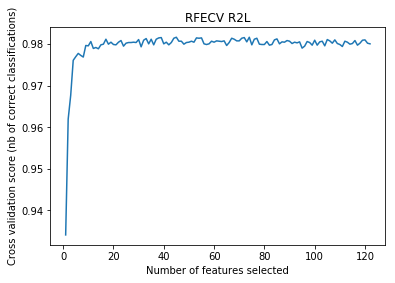

In [56]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

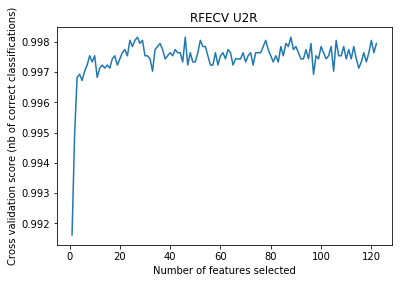

In [57]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# Using 13 Features for each category

Confusion Matrices
## DoS

In [58]:
# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
X_U2R_test2.shape

(9778, 13)

In [59]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9594,117
1,2161,5299


## Probe

In [60]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,9506,205
2,1233,1188


## R2L

In [61]:
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9711
3,2885


## U2R

In [62]:
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,62,5


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [63]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99819 (+/- 0.00191)
Precision: 0.99919 (+/- 0.00132)
Recall: 0.99665 (+/- 0.00402)
F-measure: 0.99799 (+/- 0.00240)


## Probe

In [64]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99299 (+/- 0.00385)
Precision: 0.99073 (+/- 0.00649)
Recall: 0.98906 (+/- 0.00791)
F-measure: 0.98898 (+/- 0.00850)


## R2L

In [65]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97912 (+/- 0.00660)
Precision: 0.97285 (+/- 0.01078)
Recall: 0.96792 (+/- 0.01339)
F-measure: 0.96972 (+/- 0.00983)


## U2R

In [66]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99703 (+/- 0.00170)
Precision: 0.93027 (+/- 0.15369)
Recall: 0.82723 (+/- 0.19557)
F-measure: 0.85426 (+/- 0.12230)


# Stratified CV => Stays the same

In [67]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99779 (+/- 0.00214)


In [68]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99283 (+/- 0.00430)


In [69]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97952 (+/- 0.00788)


In [70]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99683 (+/- 0.00266)


# CV 2, 5, 10, 30, 50 fold

## DoS

In [71]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99808 (+/- 0.00035)


In [72]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99802 (+/- 0.00267)


In [73]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99790 (+/- 0.00272)


In [74]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99796 (+/- 0.00351)


In [75]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99796 (+/- 0.00470)


## Probe

In [76]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99176 (+/- 0.00363)


In [77]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99299 (+/- 0.00469)


In [78]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99308 (+/- 0.00485)


In [79]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99349 (+/- 0.00693)


In [80]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99299 (+/- 0.00936)


## R2L

In [81]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97563 (+/- 0.00174)


In [82]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97968 (+/- 0.00162)


In [83]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97801 (+/- 0.00841)


In [84]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97872 (+/- 0.01522)


In [85]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97943 (+/- 0.01717)


## U2R

In [86]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99550 (+/- 0.00000)


In [87]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99642 (+/- 0.00171)


In [88]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99714 (+/- 0.00200)


In [89]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99703 (+/- 0.00462)


In [90]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99744 (+/- 0.00587)
